## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="5"
# #Ignore CPU support
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 
from mrcnn.config import Config

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


## Configurations

In [2]:
from MCNN_uboone import UbooneConfig
config = UbooneConfig()
# config.display()

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(UbooneConfig):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MAX_INSTANCES=10
#     RPN_ANCHOR_RATIOS = [0.125,0.5,1,2,4]
    DETECTION_MIN_CONFIDENCE = 0.75

config = InferenceConfig()
config.display()

Welcome to JupyROOT 6.08/06

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.02
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 1

## Notebook Preferences

In [3]:
# TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [5]:
# Build validation dataset

print config.NAME
import MCNN_uboone
if config.NAME == 'Particles':
    dataset = MCNN_uboone.UbooneDataset("/scratch/ruian/training_data/no_pion_val.root")
    dataset.load_events(100, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "minival")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Particles
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: /scratch/ruian/training_data/no_pion_val.root
    [NORMAL]  <IOManager::initialize> Prepared input with 2000 entries...
Images: 100
Classes: [0, 11, -11, 13, -13, 22, 211, -211, 2212]


## Load Model

In [6]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#Ignore CPU support
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Create model in inference mode

model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                          config=config)
model_path="/scratch/ruian/maskrcnn_log/particles20190118T2056/mask_rcnn_particles_0132.h5"
# model_path="/scratch/ruian/maskrcnn_log/particles20190109T2253/mask_rcnn_particles_0015.h5"

SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, model_path)
if config.NAME == "Particles":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
('Loading weights ', '/scratch/ruian/maskrcnn_log/particles20190118T2056/mask_rcnn_particles_0132.h5')
Re-starting from epoch 132


In [7]:
print dataset.class_info

[{'source': '', 'id': 0, 'name': 0}, {'source': 'Particles', 'id': 1, 'name': 11}, {'source': 'Particles', 'id': 2, 'name': -11}, {'source': 'Particles', 'id': 3, 'name': 13}, {'source': 'Particles', 'id': 4, 'name': -13}, {'source': 'Particles', 'id': 5, 'name': 22}, {'source': 'Particles', 'id': 6, 'name': 211}, {'source': 'Particles', 'id': 7, 'name': -211}, {'source': 'Particles', 'id': 8, 'name': 2212}]


# uB data

In [8]:
import pandas as pd
# d = {'RUN'   : [1, 1    ,     1,     1,     1,     1,     1,     1], \
#      'SUBRUN': [2, 1898 ,  2280,  2314,  2390,  3277,  6049,  8226], \
#      'EVENT' : [54, 94881,113971,115681,119473,163849,302403,411265],\
#      'VTXID' : [0,0    ,  2,        5,     0,     0,     0,     0]}
d = {'RUN'   : [1    ,     1,     1,     1,     1,     1,     1], \
     'SUBRUN': [1898 ,  2280,  2314,  2390,  3277,  6049,  8226], \
     'EVENT' : [94881,113971,115681,119473,163849,302403,411265],\
     'VTXID' : [0    ,  2,        5,     0,     0,     0,     0]}
df = pd.DataFrame(data=d)
df

,EVENT,RUN,SUBRUN,VTXID
0,94881,1,1898,0
1,113971,1,2280,2
2,115681,1,2314,5
3,119473,1,2390,0
4,163849,1,3277,0
5,302403,1,6049,0
6,411265,1,8226,0


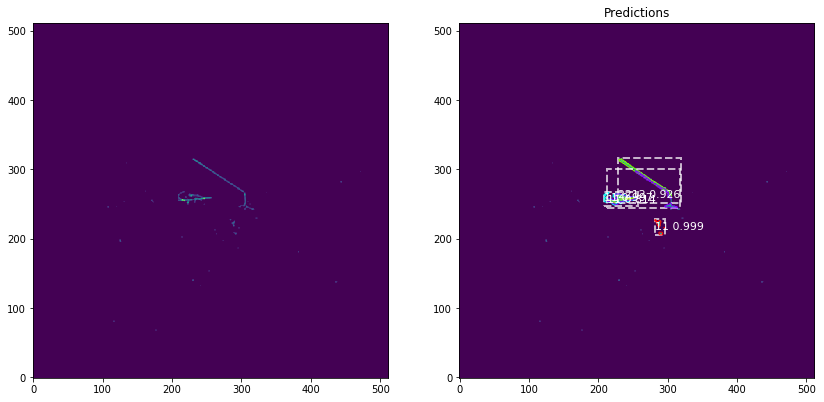

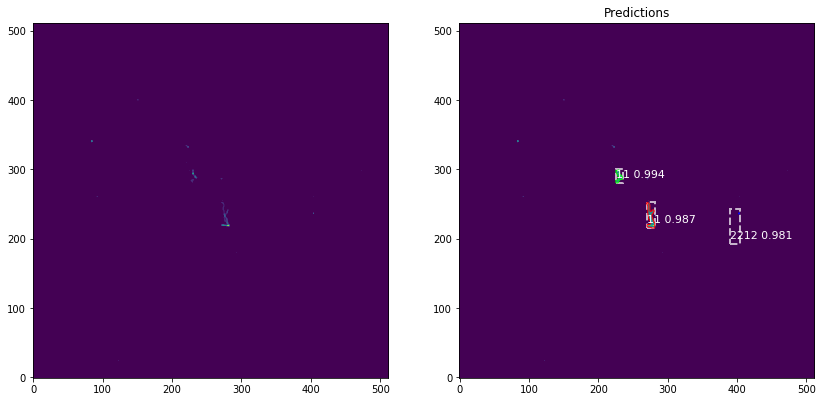

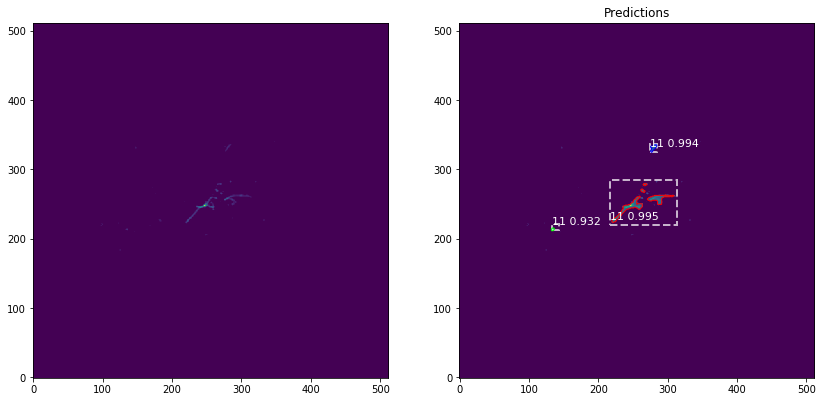

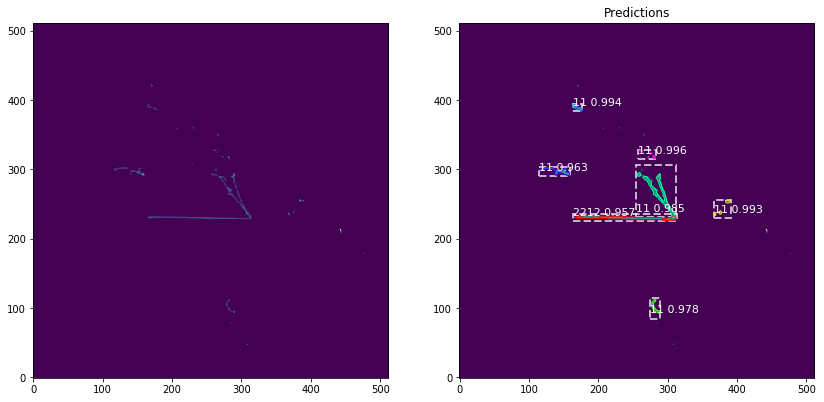

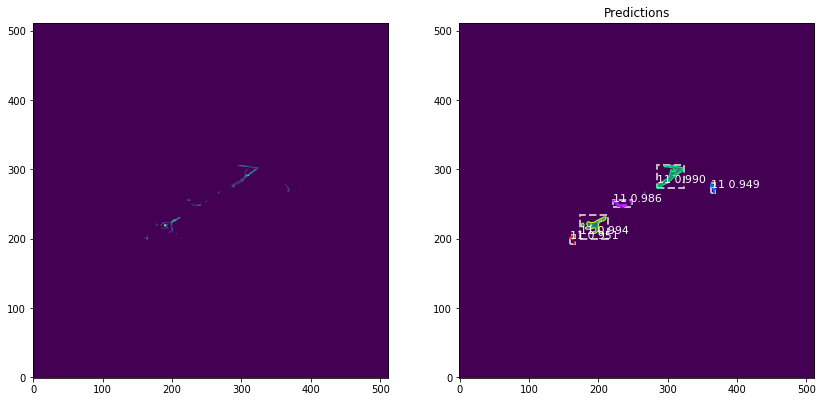

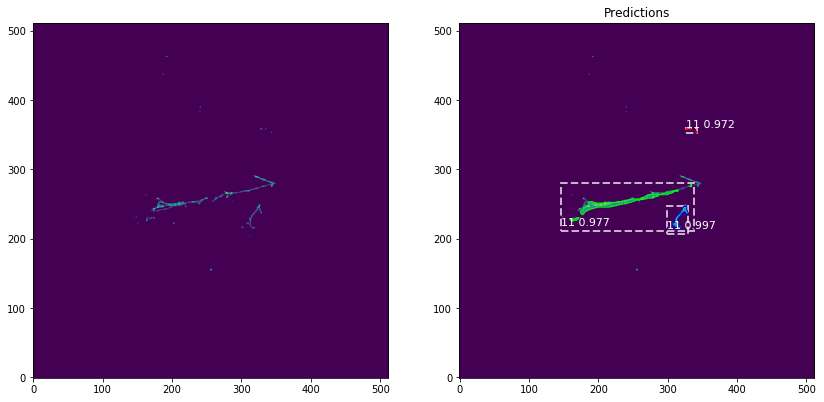

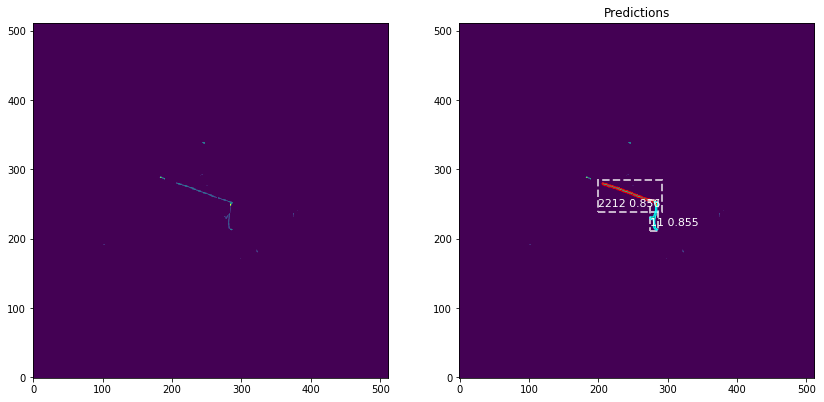

    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: /scratch/ruian/Mask_RCNN/samples/uboone/production/input/cocktail_lcv.root
    [NORMAL]  <IOManager::initialize> Prepared input with 154276 entries...
>>>>>>>>
run, subrun, event 1 1898 94881
@pgid=0
There are  2 clusters.
@plane=2
Processing 1 images
image                    shape: (512, 512, 1)         min:    0.00000  max:  312.56418  float32
molded_images            shape: (1, 512, 512, 1)      min:   -0.00100  max:  312.56318  float64
image_metas              shape: (1, 21)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
[[206 282 228 296]
 [247 209 267 257]
 [251 229 316 320]
 [244 213 301 318]]
[1 1 8 1]
[0.99860233 0.9972052  0.9259908  0.8139383 ]
>>>>>>>>
run, subrun, event 1 2280 113971
@pgid=2
There are  2 clusters.
@plane=2
Processing 1 images
image                    shape: (512, 512, 1)         min:   

In [9]:
# import gc
import ROOT
from larcv import larcv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline


def image_modify (img):
    img_arr = np.array(img.as_vector())
    img_arr = np.where(img_arr<10,0,img_arr)
#     img_arr = np.where(img_arr>cfg.adc_hi,cfg.adc_hi,img_arr)
    img_arr = img_arr.reshape(1,img_arr.size).astype(np.float32)

    return img_arr

iom  = larcv.IOManager(larcv.IOManager.kREAD)
iom.add_in_file("/scratch/ruian/Mask_RCNN/samples/uboone/production/input/cocktail_lcv.root")
iom.initialize()

for idx in xrange(7):

    RUN=df.RUN[idx]
    SUBRUN=df.SUBRUN[idx]
    EVENT=df.EVENT[idx]
    VTXID=df.VTXID[idx]

    input_image=None

    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,7))


    for entry in xrange(iom.get_n_entries()):
        iom.read_entry(entry)                                                                       

        ev_pgr = iom.get_data(larcv.kProductPGraph,"inter_par")
        ev_pix_int = iom.get_data(larcv.kProductPixel2D,"inter_int_pixel")
        ev_pix_pix = iom.get_data(larcv.kProductPixel2D,"inter_img_pixel")

        if not (ev_pix_int.run()==RUN and ev_pix_int.subrun()==SUBRUN and  ev_pix_int.event()==EVENT):continue
        print '>>>>>>>>'
        print 'run, subrun, event',ev_pix_int.run(),ev_pix_int.subrun(),ev_pix_int.event()

        for ix,pgraph in enumerate(ev_pgr.PGraphArray()):
            if not (ix == VTXID): continue
            print "@pgid=%d" % ix

            pixel2d_vv_int = ev_pix_int.Pixel2DClusterArray()
            pixel2d_vv_pix = ev_pix_pix.Pixel2DClusterArray()
            cluster_vv_int = ev_pix_int.ClusterMetaArray()

            parid = pgraph.ClusterIndexArray().front()
            roi0 = pgraph.ParticleArray().front()

            print 'There are ', pgraph.ParticleArray().size(), 'clusters.'

            x = roi0.X()
            y = roi0.Y()
            z = roi0.Z()

            y_2d_plane_0 = ROOT.Double()

            for plane in xrange(3):
                if plane == 1: continue
                if plane == 0: continue

                print "@plane=%d" % plane

                if pixel2d_vv_int.empty()==True: continue

    #             pixel2d_v_int = pixel2d_vv_int.at(plane)
    #             pixel2d_int   = pixel2d_v_int.at(ix)

    #             img_int = larcv.cluster_to_image2d(pixel2d_int,512, 512)
    #             img_arr_int = image_modify(img_int)

    #             img_arr_=img_arr_int.reshape(512,512)

                pixel2d_v_pix = pixel2d_vv_pix.at(plane)
                pixel2d_pix   = pixel2d_v_pix.at(ix)

                img_pix = larcv.cluster_to_image2d(pixel2d_pix,512, 512)
                img_arr_pix = image_modify(img_pix)

                img_arr_=img_arr_pix.reshape(512,512)

                ax1.imshow(img_arr_, origin='lower')
                input_image=img_arr_

        break

    results = model.detect([input_image.reshape(512,512,1)], verbose=1)
    # ax = get_ax(1)
    r = results[0]
    x=5
    visualize.display_instances(input_image.reshape(512,512,1), r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=ax2,
                                title="Predictions")
    
#     visualize.display_instances(input_image.reshape(512,512,1), 
#                                 np.array([r['rois'][x]]), 
#                                 np.array([r['masks'][x]]), 
#                                 np.array([r['class_ids'][x]]), 
#                                 dataset.class_names, 
#                                 np.array([r['scores'][x]]), ax=ax2,
#                                 title="Predictions")
    print r['rois']
    print r['class_ids']
    print r['scores']
    

## Run Detection on val data

In [ ]:
# for x in range(5):
# #     image_id = random.choice(dataset.image_ids)
#     image_id=x
#     image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#         modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
#     info = dataset.image_info[image_id]
#     # print image_id
#     # print info
#     # print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#     #                                        dataset.image_reference(image_id)))
#     # Run object detection
#     results = model.detect([image], verbose=1)

#     # Display results
#     ax = get_ax(1)
#     r = results[0]
#     visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                                 dataset.class_names, r['scores'], ax=ax,
#                                 title="Predictions")
# #     log("gt_class_id", gt_class_id)
# #     log("gt_bbox", gt_bbox)
# #     log("gt_mask", gt_mask)

# Truth and Detection Side by Side

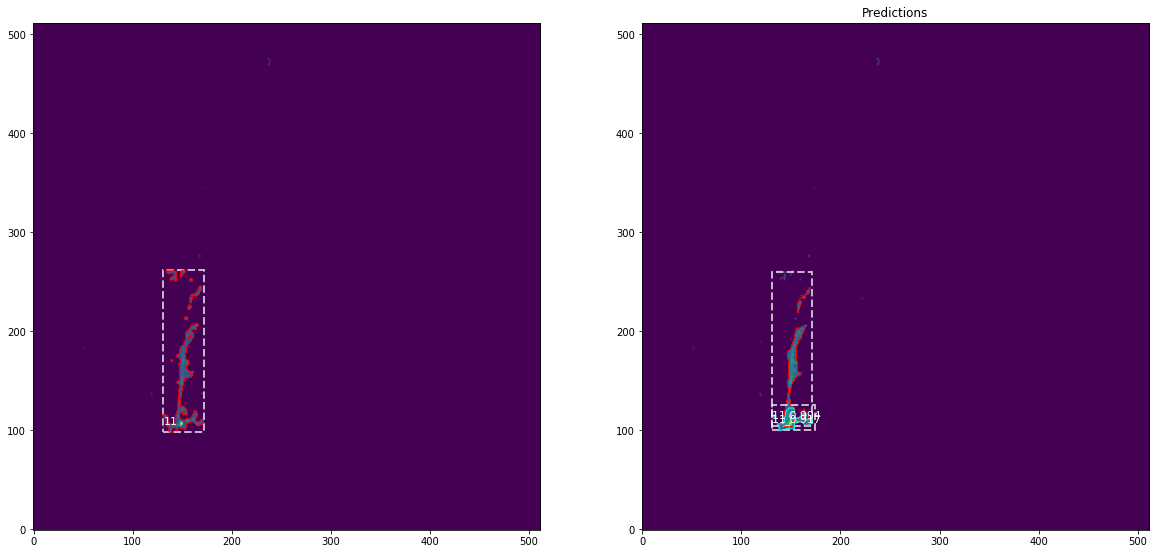

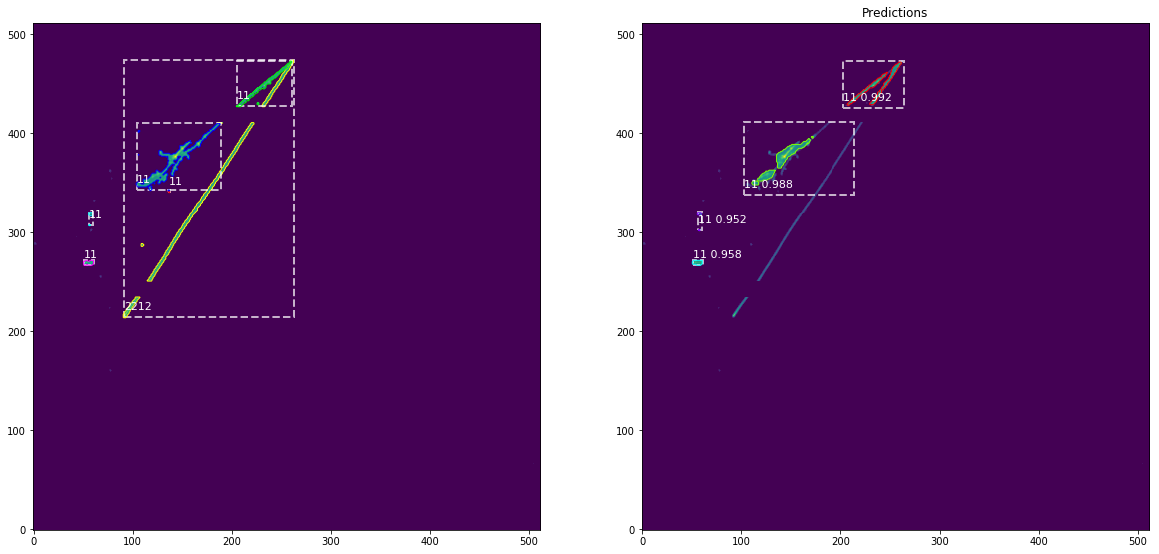

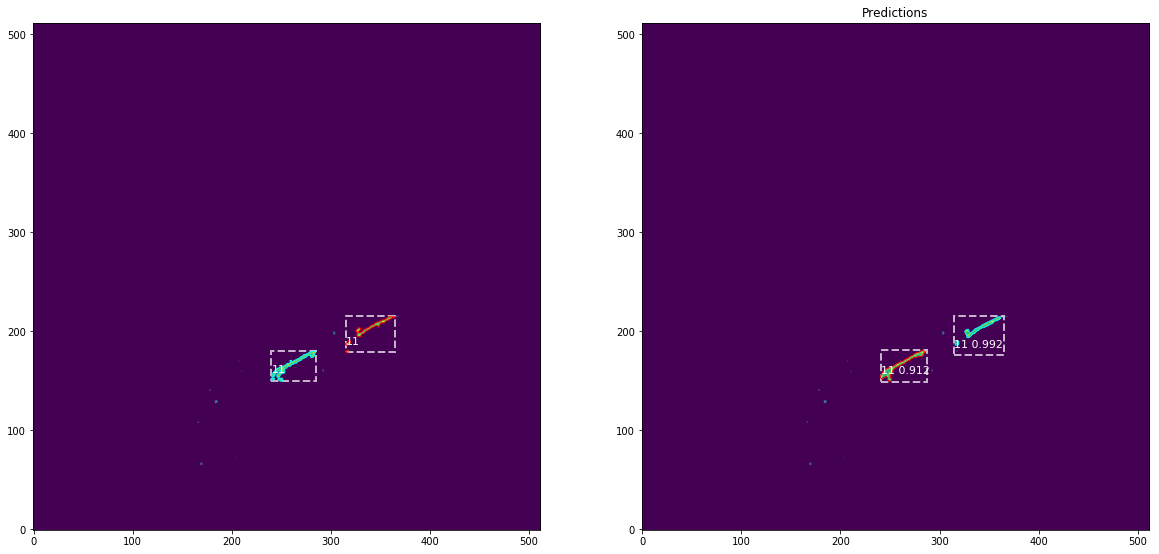

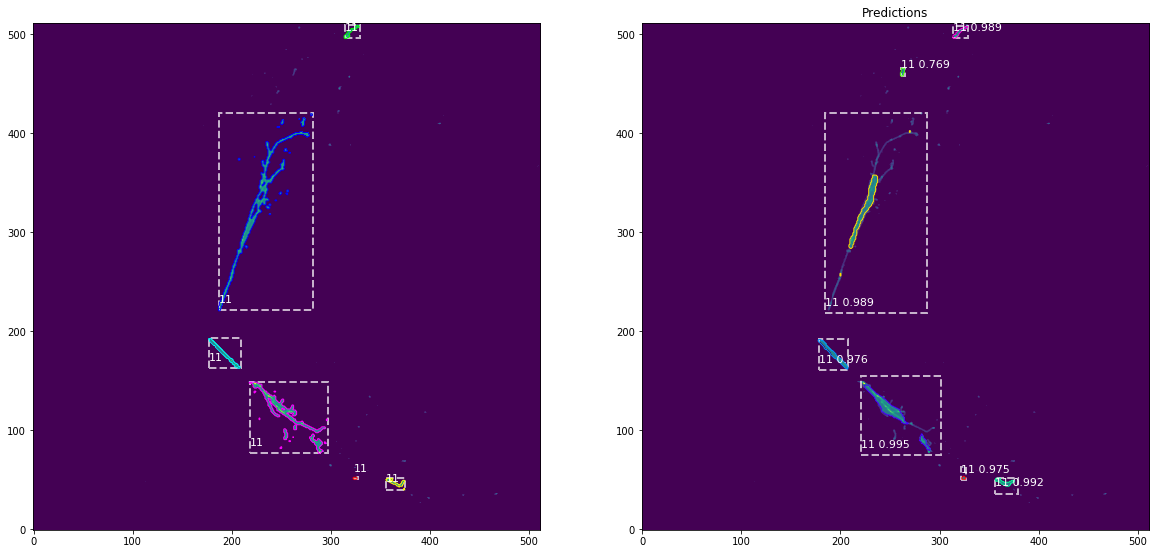

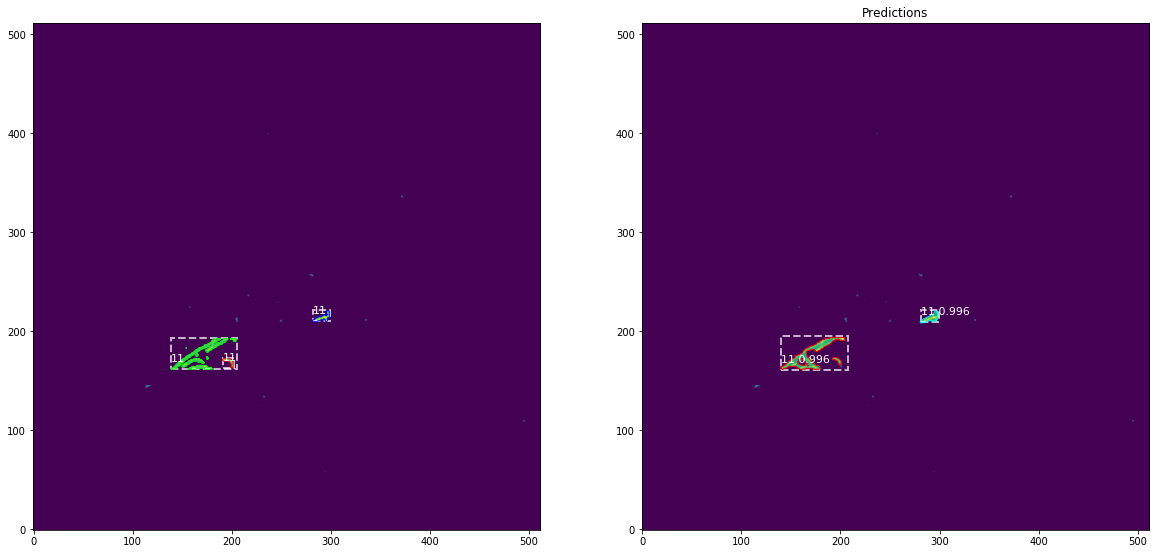

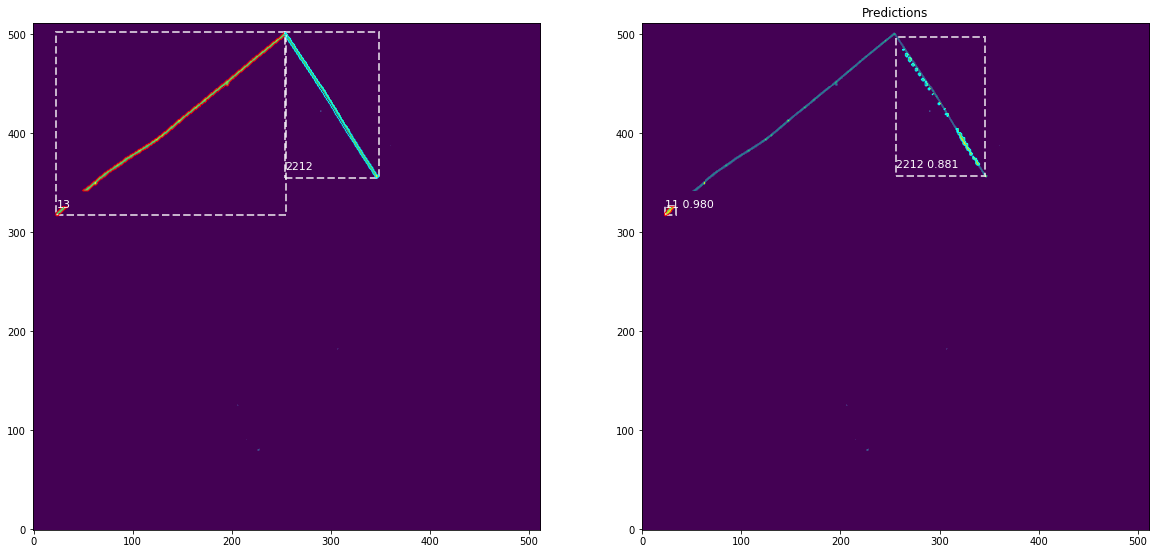

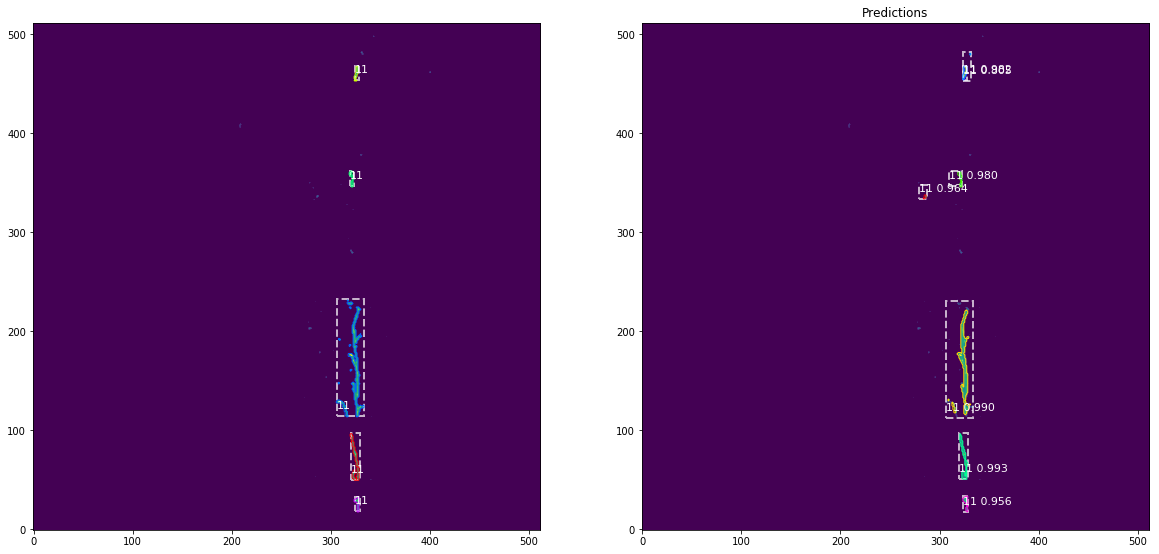

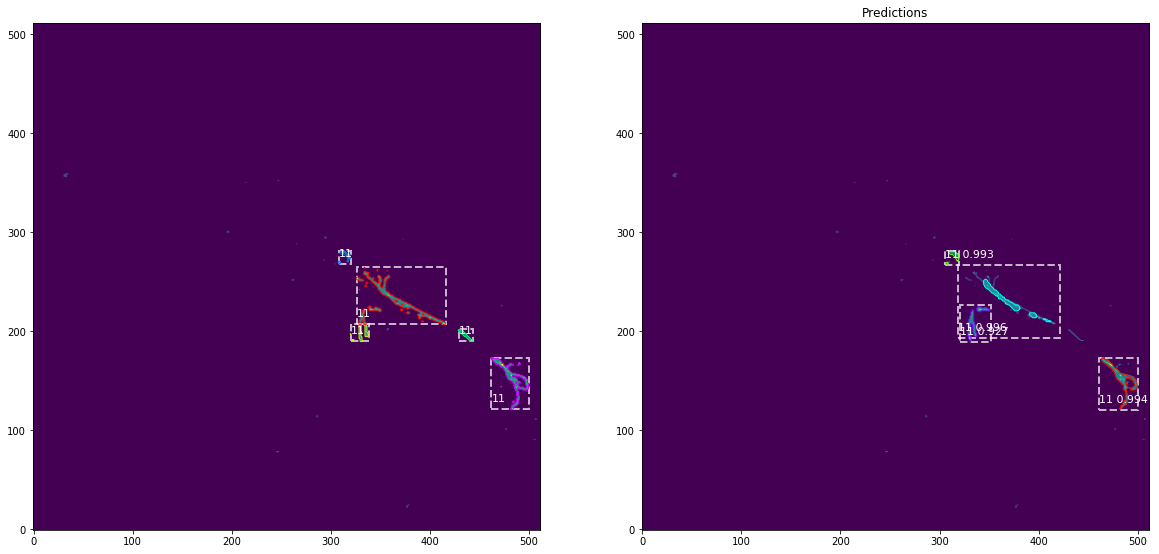

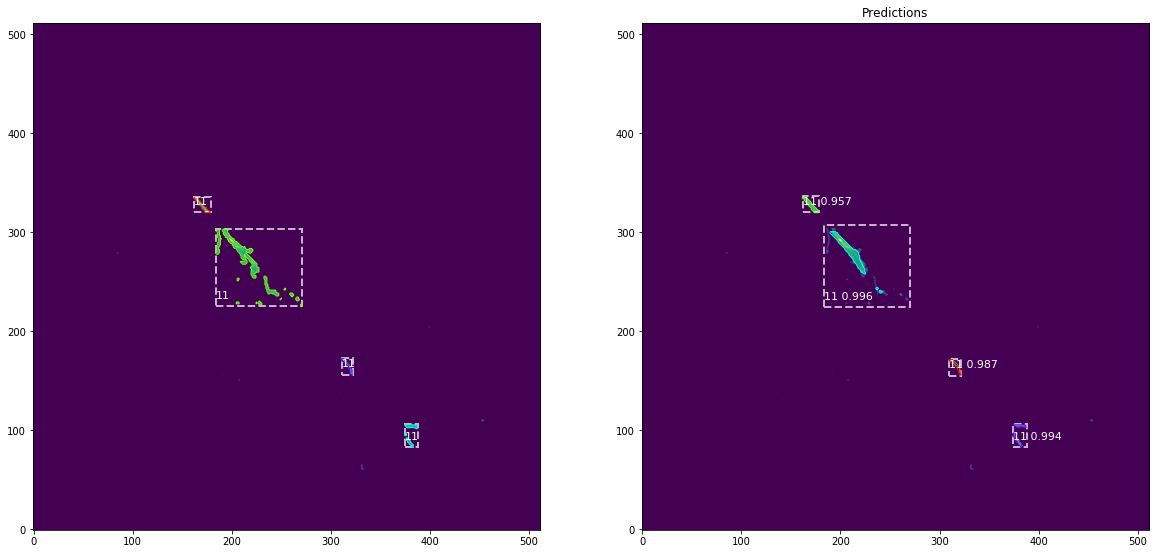

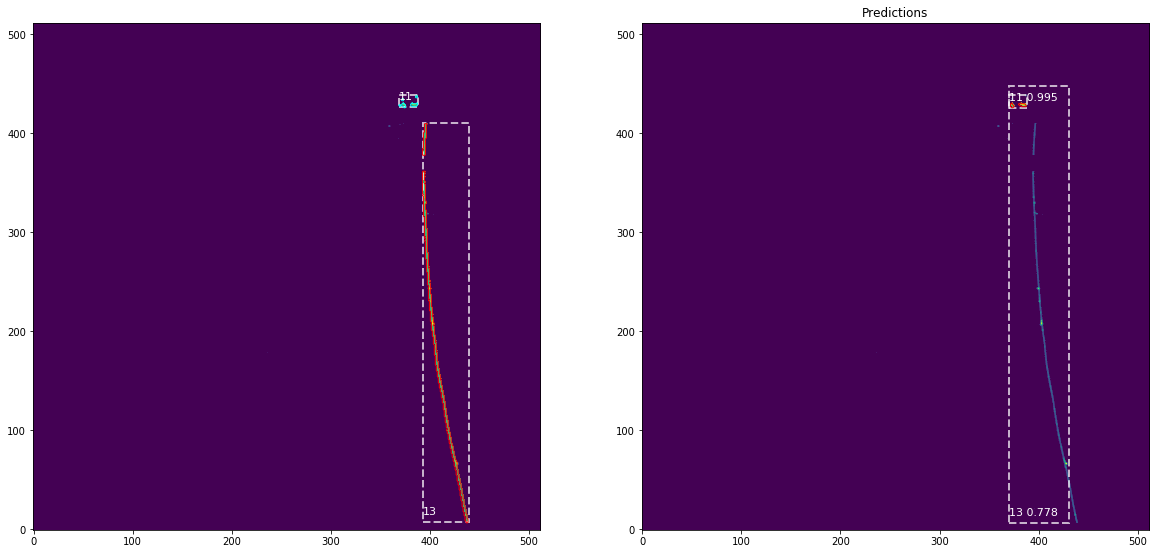

Processing 1 images
image                    shape: (512, 512, 1)         min:    0.00000  max:  956.44946  float64
molded_images            shape: (1, 512, 512, 1)      min:   -0.00100  max:  956.44846  float64
image_metas              shape: (1, 21)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Processing 1 images
image                    shape: (512, 512, 1)         min:    0.00000  max:  275.33954  float64
molded_images            shape: (1, 512, 512, 1)      min:   -0.00100  max:  275.33854  float64
image_metas              shape: (1, 21)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Processing 1 images
image                    shape: (512, 512, 1)         min:    0.00000  max:  141.79727  float64
molded_images            shape: (1, 512, 512, 1)      min:   -0.00100  max:  141

In [10]:
idx=5
# for x in range(idx,idx+1):
for x in range(10):

#     image_id = random.choice(dataset.image_ids)

    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20,10))
    
    image_id=x
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    
    visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, ax=ax0)
    
    
    
    results = model.detect([image], verbose=1)

    # Display results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=ax1,
                                title="Predictions")
    
#     ax1.text(10,450,'image_id: %i'%image_id, color='w', fontsize=25)

    
#     print '>>>>>>>>>>>>>>>>>>>'
#     print  gt_bbox
#     print [dataset.class_names[x]  for x in gt_class_id ]
    
#     print '------------'

#     print r['rois']
#     print [dataset.class_names[x]  for x in r['class_ids'] ]
#     print r['rois']
#     print r['scores']
#     print r['masks'].shape
#     for each in r['masks']:
#         print sum(each)

In [ ]:
print dataset.class_names

In [ ]:
bbs=[]
b=min([bb[0] for bb in bbs])


In [ ]:
len(dataset.image_info)

In [ ]:
# image_id = random.choice(dataset.image_ids)
# image_id=23
# print 'image_id ',image_id
for image_id in xrange(0,50):
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,8))

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               image_id, use_mini_mask=False)


    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, figsize=(8, 8),ax=ax0)
    print np.sum(original_image)
    results = model.detect([original_image], verbose=0)
    print np.sum(original_image)

    r = results[0]

    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=ax1)

### Precision-Recall

In [ ]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)
print 'AP',AP
print 'precisions',precisions
print 'recalls',recalls

In [ ]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [ ]:
reload(utils)
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets (gt)

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [ ]:
reload(utils)
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7


recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))


recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 50
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [ ]:
# Remove low confidence detections
# keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
keep = np.intersect1d(keep, np.where(roi_scores >= 0.5)[0])

print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
#     print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
#                                    keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])

if (det_mask_specific) :log("det_mask_specific", det_mask_specific)
if (det_masks): log("det_masks", det_masks)

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

In [ ]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

In [ ]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()